# Introduction

- Task : Multi-class Calssificaiton   
- Method : k-Nearest Neighborhood   
- Dataset : CIFAR-10
    - Befor running cells below, place [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) at './data/cifar-10-batches-py/' directory. Structures below :     
        - study-MLDL/data/
            - cifar-10-batches-py
            - batches.meta
            - data_batch_1
            - etc...
        - 1_k-NearestNeighbor.ipynb

# 0. Set Environment

In [89]:
import torch
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import random

from typing import List, Dict, Tuple, Union, Annotated
from tqdm import tqdm
from pprint import pprint

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Selected device:", device)

Selected device: cuda


In [91]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [92]:
data_dir = './data/cifar-10-batches-py/'

In [93]:
import time
import datetime
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time

        time_obj = datetime.timedelta(seconds= int(execution_time))
        
        print(f"Function '{func.__name__}' Execution Time {time_obj}")
        return result
    return wrapper

# 1. Process Data

In [94]:
class CustomDataset(Dataset):
    def __init__(self, 
                 data_dir: str, 
                 train: bool = True) -> None:
    
        self.data_dir = data_dir
        self.train = train

        self.data = None
        self.label = None

        self._fileloader()

    def __len__(self) -> int:

        return len(self.data)

    def __getitem__(self, 
                    idx: int) -> Tuple[Annotated[np.ndarray, 'input_dim'],
                                       Annotated[np.ndarray, '1']]:
        
        return self.data[idx], self.label[idx]
    
    def _fileloader(self) -> None:
        import os

        filestart = 'data_batch' if self.train else 'test_batch'
        file_paths = [os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.startswith(filestart)]

        for file_path in file_paths:
            self._load_and_merge(file_path)
                    
    def _unpickle(self, 
                  data_dir: str ) -> Dict:
        import pickle       

        with open(data_dir, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
            
        return dict

    def _load_and_merge(self, 
                        file_path: str) -> None:
        file = self._unpickle(file_path)
        data = file[b'data']
        label = file[b'labels']

        if self.data is None:
            self.data = data
            self.label = label
        else:
            self.data = np.vstack((self.data, data))
            self.label = np.concatenate((self.label, label))
        
        return data, label

In [95]:
train_dataset = CustomDataset(data_dir= data_dir, 
                              train= True)
test_dataset = CustomDataset(data_dir= data_dir, 
                             train= False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [96]:
def reformat_image(image: Annotated[np.ndarray, '3*32*32']) -> Annotated[np.ndarray, '32, 32, 3']:
    image = image.reshape((3, 32, 32)).transpose((1, 2, 0))
    return image

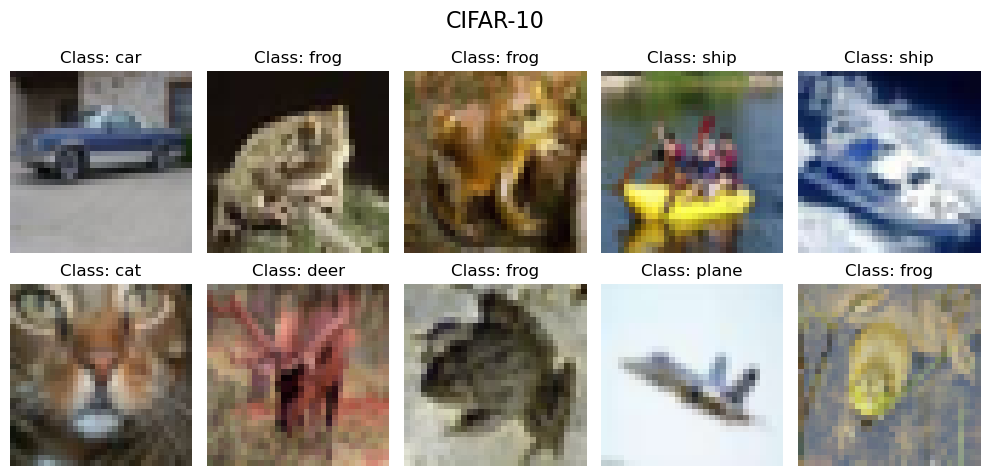

In [97]:
plt.figure(figsize=(10, 5))
plt.suptitle('CIFAR-10', fontsize=16)
for i in range(10):
    sample_image = reformat_image(train_dataset[i][0])
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_image)
    plt.axis('off')
    plt.title(f'Class: {classes[train_dataset[i][1]]}')
plt.tight_layout() 
plt.show()

# 2. Define Model

In [98]:
class NearestNeighborClassifier():
    def __init__(self,
                 distance: str = 'L1') -> None:
        
        assert distance in ['L1', 'L2'], "Distance should be 'L1' or 'L2'"
        self.distance = distance

    @timeit
    def train(self, 
              train_dataset: CustomDataset) -> None:
        # self.Xtr: np.ndarray, 'train_size, input_dim'
        # self.Ytr: np.ndarray, 'train_size'
        self.Xtr = train_dataset[:][0]
        self.Ytr = train_dataset[:][1]

    def predict(self,
                X: Annotated[np.ndarray, 'data_size, input_dim'],
                Y: Annotated[np.ndarray, 'data_size'],
                k: int)           -> np.ndarray:

        data_size = X.shape[0]
        input_dim = X.shape[1]
        Xpred = np.zeros((data_size, k, input_dim), dtype= self.Ytr.dtype)
        Ypred = np.zeros(data_size, dtype= self.Ytr.dtype)
        
        for i in tqdm(range(data_size)):
            # distances: np.ndarray, 'data_size'
            if self.distance == 'L1':
                distances = np.sum(self.Xtr - X[i,:], axis = 1)
            else:
                distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
            
            nearest_indices = np.argpartition(distances, k)[:k]
            nearest_labels = self.Ytr[nearest_indices]
            
            most_common_label = Counter(nearest_labels).most_common(1)[0][0]

            # Xpred: np.ndarray, 'data_size, k, input_dim
            # Ypred: np.ndarray, 'data_size'
            Xpred[i] = self.Xtr[nearest_indices]
            Ypred[i] = most_common_label

        return Xpred, Ypred
    
    @timeit
    def evaluate(self, 
                 test_dataset: CustomDataset,
                 k: int = 3) -> float:
        # Xte: np.ndarray, 'test_size, input_dim'
        # Yte: np.ndarray, 'test_size'
        Xte = test_dataset[:][0]
        Yte = test_dataset[:][1]

        # Ypred: np.ndarray, 'test_size'
        _, Ypred = self.predict(Xte, Yte, k)
        acc = np.mean(Yte == Ypred)

        return acc
    
    def visualize_topk(self,
                        data: Tuple[Annotated[np.ndarray, 'data_size, input_dim'],
                                    Annotated[np.ndarray, 'data_size']],
                        k: int = 10)          -> None:
        
        X, Y = data
        data_size = X.shape[0]

        Xpred, _ = self.predict(X, Y, k)
        
        plt.figure()
        plt.suptitle('Nearest Images')
        for i in range(data_size):
            original_image = reformat_image(X[i])
            plt.subplot(data_size, k+1,  i*(k+1)+1) 
            plt.imshow(original_image)
            plt.axis('off')
            plt.title(f'Class: {classes[Y[i]]}', fontsize=5)  # 제목 위치와 크기 조정

            for kth in range(k):
                kth_image = reformat_image(Xpred[i, kth])
                plt.subplot(data_size, k+1,  i*(k+1)+kth+2)
                plt.imshow(kth_image)
                plt.axis('off')
        plt.tight_layout()  # 이미지 간의 간격 조정
        plt.show()

# 3. Train

In [99]:
model = NearestNeighborClassifier(distance= 'L2')

In [100]:
model.train(train_dataset)

Function 'train' Execution Time 0:00:00


# 4. Test

In [101]:
acc = model.evaluate(test_dataset)
print(f'Accuracy : {acc:.3f}')

100%|██████████| 10000/10000 [14:22<00:00, 11.59it/s]

Function 'evaluate' Execution Time 0:14:22
Accuracy : 0.238


# 5. Inference

100%|██████████| 5/5 [00:00<00:00, 11.41it/s]


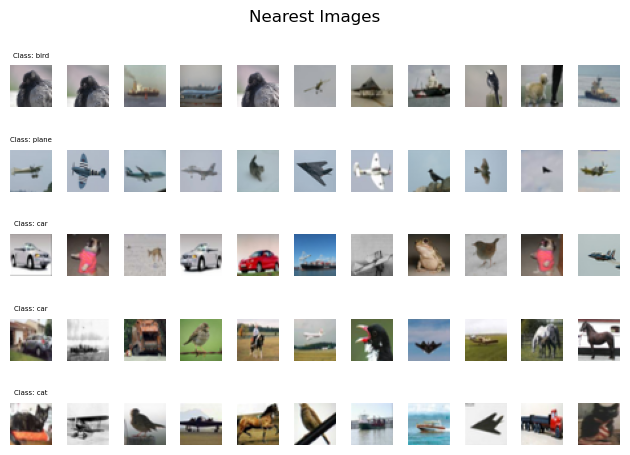

In [102]:
random_idx = random.randint(0, 10000-5)
model.visualize_topk(test_dataset[random_idx:random_idx+5], k= 10)